# Определение токсичных комментариев (BERT)

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


---

**КОНТЕКСТ ИССЛЕДОВАНИЯ:**  набор данных с разметкой о токсичности правок

---

**ЦЕЛЬ ИССЛЕДОВАНИЯ:** обучить модель классифицировать комментарии на позитивные и негативные.

---

**ПЛАН ИССЛЕДОВАНИЯ**:

- Загрузить данные и изучить общую информацию о данных
- Подготовить данные для обучения при помощи BERT
- Обучить разные модели с различными гиперпараметрами.
- Выбрать лучшую модель и проверить ее качество на тестовой выборке

---

**КРИТЕРИИ УСПЕХА И ПРИМЕЧАНИЯ:**

- Значение метрики качества **F1** не меньше 0.75

---

**Описание данных для первого исследования:**

*Столбец text содержит текст комментария, а toxic — целевой признак*

## Загрузка и изучение данных

In [1]:
!pip install tqdm -q
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install -U scikit-learn
!pip install torch
!pip install transformers

import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformers
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from tqdm import notebook
from transformers import AutoTokenizer, AutoModel
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Загружаем датасеты для первой задачи
try:
    data = pd.read_csv('toxic_comments.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
display(data.head())
display(data.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [4]:
print('Кол-во явных дубликатов:', data.duplicated().sum())
print('Кол-во пропусков:\n', data.isna().sum())

Кол-во явных дубликатов: 0
Кол-во пропусков:
 Unnamed: 0    0
text          0
toxic         0
dtype: int64


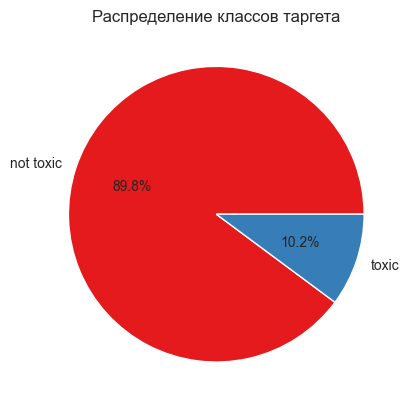

In [5]:
# Построим график распределения классов таргета
plt.pie(
    data['toxic'].value_counts(),
    labels=[
        'not toxic',
        'toxic',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Распределение классов таргета')
plt.grid()
plt.show()

---
- Обнаружили дисбаланс классов таргета. Учтем это при обучении моделей
- Данные чистые, пропусков и дубликатов нет. Отлично! Можем приступать к следующим шагам

---

## Подготовка данных 

In [6]:
RANDOM_STATE = 42

# Выделим 10000 случайных строк из всего датасета для ускорения обучения
data_sampled = data.sample(10000, random_state=RANDOM_STATE).reset_index(drop=True)

display(data.shape)
display(data_sampled.shape)

(159292, 3)

(10000, 3)

In [7]:
# Токенизируем текст предобученным токенайзером
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
tokenized = data_sampled['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

# Найдем максимальную длину токенов
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# Ограничим длину токенов и создадим маску
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
display(padded.shape, attention_mask.shape)

(10000, 512)

(10000, 512)

In [8]:
%%time

# Загрузим предобученную модель
try:
    config = transformers.BertConfig.from_json_file(
        'config.json')
except:
    config = transformers.BertConfig.from_json_file(
        'https://huggingface.co/unitary/toxic-bert/tree/main/config.json')

model = AutoModel.from_pretrained('unitary/toxic-bert')

# Получим эмбеддинги
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

# Соберем все эмбеддинги в один массив
X = np.concatenate(embeddings)
y = data_sampled['toxic']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 15h 47min 25s, sys: 1h 26min 54s, total: 17h 14min 20s
Wall time: 2h 19min 45s


In [9]:
TEST_SIZE = 0.2

# Разделим данные на фичи и таргет
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

display(X_train.shape, X_test.shape)
display(y_train.shape, y_test.shape)

(8000, 768)

(2000, 768)

(8000,)

(2000,)

## Обучение моделей

In [10]:
# Создадим пустой словарь для хранения результатов
results = {
    'model': [],
    'f1_val': [],
}

### `LogisticRegression`

In [11]:
# Обучим модель
lr_model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)

# Посчитаем метрику на кросс-валидации
lr_f1_val = cross_val_score(
    lr_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
).mean()

# Сохраним результаты
results['model'].append('LogisticRegression')
results['f1_val'].append(lr_f1_val)

### `CatBoostClassifier`

In [12]:
%%time

# Переберем гиперпараметры
cat_params = {
    'depth': range(3, 10),
    'learning_rate': [0.03, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 7, 9],
}

cat_model = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True)

cat_search = RandomizedSearchCV(
    cat_model,
    cat_params,
    n_iter=100,
    verbose=5,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
)

cat_search.fit(X_train, y_train)
cat_best_model = cat_search.best_estimator_
cat_f1_val = cat_search.best_score_

# Сохраним результаты
results['model'].append('CatBoostClassifier')
results['f1_val'].append(cat_f1_val)

/Users/maxtiandi/anaconda3/envs/practicum/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 84 is smaller than n_iter=100. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1d 4h 29min 18s, sys: 26min 5s, total: 1d 4h 55min 23s
Wall time: 3h 55min 10s


### `LGBMClassifier`

In [13]:
%%time

# Переберем гиперпараметры
lgbm_params = {
    'n_estimators': range(100, 350),
    'max_depth': range(3, 10),
    'learning_rate': [0.1, 0.01, 0.001],
}

lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

lgbm_search = RandomizedSearchCV(
    lgbm_model,
    lgbm_params,
    n_iter=100,
    verbose=5,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
)

lgbm_search.fit(X_train, y_train)
lgbm_best_model = lgbm_search.best_estimator_
lgbm_f1_val = lgbm_search.best_score_

# Сохраним результаты
results['model'].append('LGBMClassifier')
results['f1_val'].append(lgbm_f1_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CPU times: user 40min 54s, sys: 12min 43s, total: 53min 37s
Wall time: 16min 26s


### `XGBClassifier`

In [14]:
%%time

# Переберем гиперпараметры
xgb_params = {
    'n_estimators': range(100, 350),
    'max_depth': range(3, 10),
    'learning_rate': [0.1, 0.01, 0.001],
}

xgb_model = XGBClassifier(random_state=RANDOM_STATE)

xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=100,
    verbose=5,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
)

xgb_search.fit(X_train, y_train)
xgb_best_model = xgb_search.best_estimator_
xgb_f1_val = xgb_search.best_score_

# Сохраним результаты
results['model'].append('XGBClassifier')
results['f1_val'].append(xgb_f1_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 2h 21min 59s, sys: 50min 58s, total: 3h 12min 58s
Wall time: 21min 22s


## Тестирование лучшей модели

In [15]:
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='f1_val', ascending=False))

,model,f1_val
1,CatBoostClassifier,0.957883
3,XGBClassifier,0.953041
2,LGBMClassifier,0.952486
0,LogisticRegression,0.947330


---

Модель, показавшая лучшую усредненную метрику на кросс-валидации - `CatBoostClassifier`. Проверим ее качество на тестовой выборке!

---

In [16]:
# Проверим качество модели на тестовой выборке
predictions = cat_best_model.predict(X_test)
cat_f1_test = f1_score(y_test, predictions)
print('F1 лучшей модели на тестовой выборке:', cat_f1_test)

F1 лучшей модели на тестовой выборке: 0.93734335839599


## Общий вывод

**В ходе исследования была выбрана и обучена лучшая модель, способная классифицировать комментарии на положительные и негативные**

- Изначальные данные в хорошем состоянии, предобработка не понадобилась
- Токенизировали данные при помощи предобученной модели BERT, специализирующейся на токсичных комментариях (взята из Toxic контеста)
- Перебрали гиперпараметры 4-х моделей, проверили усредненное качество метрики `F1-меры` на кросс-валидации:
    - `CatBoostClassifier` - лидер, со значением F1 на cross_val = **0.957883**
    - `XGBClassifier` - *0.953041*
    - `LGBMClassifier` - *0.952486*
    - `LogisticRegression` - *0.947330*

- `F1` лучшей модели на тестовой выборке: **0.93734335839599**

Конечный результат получился выше критерия успеха заказчика - получили отличное значение метрики :) 